In [17]:
%matplotlib notebook 

import numpy
import scipy.optimize
import matplotlib.pyplot as plot

In [18]:
import matplotlib
matplotlib.rc('text', usetex=True)

In [19]:
numpy.random.seed(1234)

In [20]:
# data set generation
n_dim = 2
n_mean = numpy.array([0., -1.])
n_cov = numpy.diag([0.2, .5])
p_mean = numpy.array([1., 1.])
p_cov = numpy.diag([.5, .3])

# generate postive examples
n_pos = 50
pos_y = numpy.ones(n_pos) 
pos_x = numpy.random.randn(n_pos, n_dim) * numpy.diag(p_cov)[None, :] + p_mean[None,:]
# generate negative examples
n_neg = 50
neg_y = numpy.zeros(n_neg)
neg_x = numpy.random.randn(n_neg, n_dim) * numpy.diag(n_cov)[None, :] + n_mean[None,:]
# combine them
y = numpy.concatenate([pos_y, neg_y])
x = numpy.concatenate([pos_x, neg_x], axis=0)
# shuffle them
si = numpy.random.permutation(n_pos + n_neg)
y = y[si]
x = x[si]

# grab training examples
n_tra = numpy.round(0.5 * (n_pos + n_neg)).astype(numpy.int)

y_tra = y[:n_tra]
x_tra = x[:n_tra]

y_tes = y[n_tra:]
x_tes = x[n_tra:]

In [21]:
def sigmoid(a):
    return 1. / (1. + numpy.exp(-a))

In [22]:
def logreg(x, w, pre=False):
    x = x.reshape([1, -1]) if len(x.shape) < 2 else x
    
    y = numpy.sum(x * w[None,:-1], axis=1) + w[-1]
    if pre:
        return y    
    return sigmoid(y)

In [23]:
def logreg_dist(y, x, w, avg=False):
    y_ = logreg(x, w)
    
    d = -(y * numpy.log(y_ + 1e-12) + (1. - y) * numpy.log(1-y_ + 1e-12))
    
    if not avg:
        return d
    return numpy.mean(d)

In [42]:
def logreg_rule(y, x, w):
    y_ = logreg(x, w)
    dw = numpy.zeros(w.shape)
    dw[:-1] = numpy.mean((y_ - y_tra)[:, None] * x, axis=0)
    dw[-1] = numpy.mean(y_ - y_tra)
    return dw

In [43]:
def _logreg_dist(w, x, y, avg=False):
    return logreg_dist(y, x, w, avg=avg), logreg_rule(y, x, w)

In [44]:
w0 = 0.01 * numpy.random.randn(n_dim+1); w0[-1] = 0.
w = numpy.copy(w0)

res = scipy.optimize.minimize(_logreg_dist, w0, (x_tra, y_tra, False), method='L-BFGS-B', jac=True)

In [45]:
print res
w = res.x

      fun: array([  7.60621043e-08,   3.94708599e-10,   1.95833339e-09,
         9.53413725e-05,  -9.90318938e-13,   4.33560166e-09,
         1.05915277e-13,   5.97244533e-09,   3.28501594e-04,
         4.45144750e-04,   1.21311405e-10,   4.40350978e-10,
         7.89368571e-14,   8.54027959e-12,   1.60904623e-12,
         2.78843272e-07,   1.09610820e-09,   4.38976300e-10,
         1.60845781e-11,   7.52250484e-11,   3.55941943e-11,
         2.37409004e-09,   7.05037695e-10,   1.09324542e-07,
         9.11578516e-08,   6.78768153e-12,   3.91089618e-04,
         1.05659224e-08,   1.70629153e-06,   1.33084142e-07,
         3.50290907e-11,   2.56782484e-10,   2.36517709e-06,
         1.14405652e-07,   1.87451499e-10,   6.08203584e-08,
        -8.02025113e-13,   4.22828661e-10,   1.12674645e-07,
         1.47868384e-11,   7.74870168e-11,   8.79263329e-12,
         1.27031017e-07,  -9.52127266e-13,  -7.37410133e-13,
        -8.86624107e-13,   3.70606323e-10,   5.27540690e-09,
         6.27

In [46]:
# visualize data 
def vis_data(x, y = None, c='r'):
    if y is None: 
        y = [None] * len(x)
    plot.hold('on')
    for x_, y_ in zip(x, y):
        if y_ is None:
            plot.plot(x_[0], x_[1], 'o', markerfacecolor='none', markeredgecolor=c)
        else:
            plot.plot(x_[0], x_[1], c+'o' if y_ == 0 else c+'+')
    plot.hold('off')
    plot.grid('on')

In [47]:
def vis_hyperplane(w, typ='k--'):
    plot.hold('on')

    lim0 = plot.gca().get_xlim()
    lim1 = plot.gca().get_ylim()
    m0, m1 = lim0[0], lim0[1]

    intercept0 = -(w[0] * m0 + w[-1])/w[1]
    intercept1 = -(w[0] * m1 + w[-1])/w[1]
    
    plt1, = plot.plot([m0, m1], [intercept0, intercept1], typ)

    plot.gca().set_xlim(lim0)
    plot.gca().set_ylim(lim1)
    
    plot.hold('off')
    
    return plt1

<IPython.core.display.Javascript object>


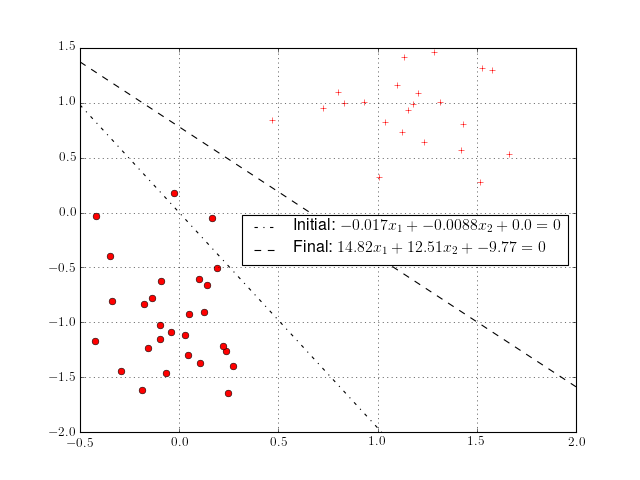

In [48]:
plot.figure()

vis_data(x_tra, y_tra, c='r')
#vis_data(x_tes, y_tes, c='b')

plt0 = vis_hyperplane(w0, 'k-.')
plt1 = vis_hyperplane(w, 'k--')
plot.legend([plt0, plt1], [
        'Initial: ${:.2} x_1 + {:.2} x_2 + {:.2} = 0$'.format(*list(w0)),
        'Final: ${:.2f} x_1 + {:.2f} x_2 + {:.2f} = 0$'.format(*list(w))],
           loc='best')

plot.show()

In [49]:
tra_er = numpy.sum(numpy.abs(numpy.round(logreg(x_tra, w)) - y_tra)) / numpy.float(len(y_tra))
tes_er = numpy.sum(numpy.abs(numpy.round(logreg(x_tes, w)) - y_tes)) / numpy.float(len(y_tes))

print 'Training error rate {}, Test error rate {}'.format(tra_er, tes_er)

Training error rate 0.0, Test error rate 0.0
